In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Required Library
!pip install seqeval==0.0.12

  Created wheel for seqeval: filename=seqeval-0.0.12-py3-none-any.whl size=7423 sha256=fdd0646dd72ab05d37e7f110b8638cb7cd9c62d9fa9a8bfe9942849c1a0ecff6
  Stored in directory: /root/.cache/pip/wheels/1f/1b/a6/a808a7e4d1f7584e42f5e279664cd48bf24ed8392218ce6be4
Successfully built seqeval


In [3]:
# Importing required Libraries
import pandas as pd
import math
import numpy as np
from seqeval.metrics import f1_score
from seqeval.metrics import classification_report,accuracy_score,f1_score
import torch.nn.functional as F
import torch
import os
from tqdm import tqdm,trange
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import json
import random
import logging
import re
import torch
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertForTokenClassification, BertAdam

Using TensorFlow backend.


In [4]:
data_file_address = "../input/resume-entities-for-ner//Entity Recognition in Resumes.json"

In [5]:
# Reading data
df = pd.read_json(data_file_address, lines=True)
df.head(10)

,content,annotation,extras
0,Abhishek Jha\nApplication Development Associat...,"[{'label': ['Skills'], 'points': [{'start': 12...",NaN
1,Afreen Jamadar\nActive member of IIIT Committe...,"[{'label': ['Email Address'], 'points': [{'sta...",NaN
2,"Akhil Yadav Polemaina\nHyderabad, Telangana - ...","[{'label': ['Skills'], 'points': [{'start': 37...",NaN
3,Alok Khandai\nOperational Analyst (SQL DBA) En...,"[{'label': ['Skills'], 'points': [{'start': 80...",NaN
4,Ananya Chavan\nlecturer - oracle tutorials\n\n...,"[{'label': ['Degree'], 'points': [{'start': 20...",NaN
5,Anvitha Rao\nAutomation developer\n\n- Email m...,"[{'label': ['Skills'], 'points': [{'start': 28...",NaN
6,arjun ks\nSenior Program coordinator - oracle ...,"[{'label': ['Skills'], 'points': [{'start': 34...",NaN
7,"Arun Elumalai\nQA Tester\n\nChennai, Tamil Nad...","[{'label': ['Skills'], 'points': [{'start': 19...",NaN
8,Ashalata Bisoyi\nTransaction Processor - Oracl...,"[{'label': ['Skills'], 'points': [{'start': 17...",NaN
9,Ashok Kunam\nTeam Lead - Microsoft\n\n- Email ...,"[{'label': ['Skills'], 'points': [{'start': 41...",NaN


In [6]:
df["content"] = df["content"].apply(lambda text: text.replace("\n", " "))

In [7]:
# JSON formatting functions
def convert_dataturks_to_spacy(dataturks_JSON_FilePath):
    try:
        training_data = []
        lines=[]
        with open(dataturks_JSON_FilePath, 'r') as f:
            lines = f.readlines()

        for line in lines:
            data = json.loads(line)
            text = data['content'].replace("\n", " ")
            entities = []
            data_annotations = data['annotation']
            if data_annotations is not None:
                for annotation in data_annotations:
                    #only a single point in text annotation.
                    point = annotation['points'][0]
                    labels = annotation['label']
                    # handle both list of labels or a single label.
                    if not isinstance(labels, list):
                        labels = [labels]

                    for label in labels:
                        point_start = point['start']
                        point_end = point['end']
                        point_text = point['text']
                        
                        lstrip_diff = len(point_text) - len(point_text.lstrip())
                        rstrip_diff = len(point_text) - len(point_text.rstrip())
                        if lstrip_diff != 0:
                            point_start = point_start + lstrip_diff
                        if rstrip_diff != 0:
                            point_end = point_end - rstrip_diff
                        entities.append((point_start, point_end + 1 , label))
            training_data.append((text, {"entities" : entities}))
        return training_data
    except Exception as e:
        logging.exception("Unable to process " + dataturks_JSON_FilePath + "\n" + "error = " + str(e))
        return None

def trim_entity_spans(data: list) -> list:
    """Removes leading and trailing white spaces from entity spans.

    Args:
        data (list): The data to be cleaned in spaCy JSON format.

    Returns:
        list: The cleaned data.
    """
    invalid_span_tokens = re.compile(r'\s')

    cleaned_data = []
    for text, annotations in data:
        entities = annotations['entities']
        valid_entities = []
        for start, end, label in entities:
            valid_start = start
            valid_end = end
            while valid_start < len(text) and invalid_span_tokens.match(
                    text[valid_start]):
                valid_start += 1
            while valid_end > 1 and invalid_span_tokens.match(
                    text[valid_end - 1]):
                valid_end -= 1
            valid_entities.append([valid_start, valid_end, label])
        cleaned_data.append([text, {'entities': valid_entities}])
    return cleaned_data        

In [8]:
data = trim_entity_spans(convert_dataturks_to_spacy(data_file_address))
data[0]

["Abhishek Jha Application Development Associate - Accenture  Bengaluru, Karnataka - Email me on Indeed: indeed.com/r/Abhishek-Jha/10e7a8cb732bc43a  • To work for an organization which provides me the opportunity to improve my skills and knowledge for my individual and company's growth in best possible ways.  Willing to relocate to: Bangalore, Karnataka  WORK EXPERIENCE  Application Development Associate  Accenture -  November 2017 to Present  Role: Currently working on Chat-bot. Developing Backend Oracle PeopleSoft Queries for the Bot which will be triggered based on given input. Also, Training the bot for different possible utterances (Both positive and negative), which will be given as input by the user.  EDUCATION  B.E in Information science and engineering  B.v.b college of engineering and technology -  Hubli, Karnataka  August 2013 to June 2017  12th in Mathematics  Woodbine modern school  April 2011 to March 2013  10th  Kendriya Vidyalaya  April 2001 to March 2011  SKILLS  C (Le

In [9]:
# Changing data to appropriate format so as to feed it to the model
from tqdm import tqdm_notebook as tqdm


clean_entities = []

for i in tqdm(range(len(data))): 
    start = 0
    emptyList = ["Empty"] * len(data[i][0].split())
    numberOfWords = 0
    lenOfString = len(data[i][0])
    strData = data[i][0]
    strDictData = data[i][1]

    lastIndexOfSpace = strData.rfind(' ')
    for i in range(lenOfString):
        if (strData[i]==" " and strData[i+1]!=" "):
            for k,v in strDictData.items():
                for j in range(len(v)):
                    entList = v[len(v)-j-1]
                    if (start>=int(entList[0]) and i<=int(entList[1])):
                        emptyList[numberOfWords] = entList[2]
                        break
                    else:
                        continue
            start = i + 1  
            numberOfWords += 1
        if (i == lastIndexOfSpace):
            for j in range(len(v)):
                    entList = v[len(v)-j-1]
                    if (lastIndexOfSpace>=int(entList[0]) and lenOfString<=int(entList[1])):
                        emptyList[numberOfWords] = entList[2]
                        numberOfWords += 1
    clean_entities.append(emptyList)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


In [10]:
device = torch.device("cuda") 
# I get error CUDA error: device-side assert triggered so i have to use gpu
# device = torch.device("cpu")

n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0) 

'Tesla P100-PCIE-16GB'

In [11]:
MAX_LEN = 300
batch_size = 16

In [12]:
tags = list(set([ent for ent_list in clean_entities for ent in ent_list]))
tag2idx = {t: i for i, t in enumerate(tags)}

words_tags = pad_sequences([[tag2idx[l] for l in lab] for lab in clean_entities],
                     maxlen=MAX_LEN, value=tag2idx["Empty"], padding="post",
                     dtype="long", truncating="post")


In [13]:
from transformers import RobertaTokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split


In [14]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', do_lower_case=True)

In [15]:
tokenized_data = [
    tokenizer.encode_plus(
        text,
        add_special_tokens=True,  # Добавляет специальные токены [CLS], [SEP]
        max_length=MAX_LEN, 
        pad_to_max_length=True, # Ограничиваем максимальную длину
        padding='max_length',     # Паддинг до MAX_LEN
        truncation=True,          # Усечение длины
        return_attention_mask=True,  # Возвращает маску внимания
        return_tensors='pt'      # Возвращает тензоры PyTorch
    ) for text in df["content"]
]


input_ids = torch.cat([item['input_ids'] for item in tokenized_data], dim=0)
attention_masks = torch.cat([item['attention_mask'] for item in tokenized_data], dim=0)

In [16]:
len(words_tags[2])

300

In [17]:
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, words_tags, 
                                                            random_state=7, test_size=0.1)

# Разделение масок внимания
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids, 
                                             random_state=7, test_size=0.1)

In [18]:
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detac

In [19]:
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=batch_size)


In [20]:
from transformers import RobertaForTokenClassification
# from transformers import AlbertForTokenClassification
from transformers import AdamW

In [21]:
model_name = 'roberta-base' 
model = RobertaForTokenClassification.from_pretrained(model_name, num_labels=len(tag2idx))
# model_name = 'albert-base-v2' 
# model = AlbertForTokenClassification.from_pretrained(model_name, num_labels=len(tag2idx))

In [22]:
# for param in model.roberta.parameters():
#     param.requires_grad = False

# # Размораживаем последние слои
# for param in model.roberta.encoder.layer[-1].parameters():
#     param.requires_grad = True

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']

# Группируем параметры для оптимизатора с учетом weight decay
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

# Инициализируем оптимизатор
optimizer = AdamW(optimizer_grouped_parameters, lr=3e-5)

In [23]:
model.cuda();

In [24]:
from seqeval.metrics import f1_score

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=2).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [25]:
test_loss = []
test_f1 = []
test_acc = []
train_loss = []

In [26]:
epochs = 8
max_grad_norm = 1.0

for _ in trange(epochs, desc="Epoch"):
    # TRAIN loop
    model.train()
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        
        # forward pass
        loss = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)[0]
        
        loss.backward()
        # track train loss
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1
        
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        
        # update parameters
        optimizer.step()
        model.zero_grad()
    
    print("Train loss: {}".format(tr_loss/nb_tr_steps))
    train_loss.append(tr_loss/nb_tr_steps)

    # VALIDATION on validation set
    model.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions, true_labels = [], []
    
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        
        with torch.no_grad():
            tmp_eval_loss = model(b_input_ids, token_type_ids=None,
                                  attention_mask=b_input_mask, labels=b_labels)[0]
            logits = model(b_input_ids, token_type_ids=None,
                           attention_mask=b_input_mask)[0]

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.append(label_ids)

        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        eval_loss += tmp_eval_loss.mean().item()
        eval_accuracy += tmp_eval_accuracy
        nb_eval_examples += b_input_ids.size(0)
        nb_eval_steps += 1

    eval_loss = eval_loss / nb_eval_steps
    
    

    print("Validation loss: {}".format(eval_loss))
    print("Validation Accuracy: {}".format(eval_accuracy / nb_eval_steps))
    
    pred_tags = [tags[p_i] for p in predictions for p_i in p]
    valid_tags = [tags[l_ii] for l in true_labels for l_i in l for l_ii in l_i]
    print("F1-Score: {}".format(f1_score(pred_tags, valid_tags)))
    
    test_loss.append(eval_loss)
    test_f1.append(f1_score(pred_tags, valid_tags))
    test_acc.append(eval_accuracy / nb_eval_steps)


Epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Train loss: 1.2345748474964728


Epoch:  12%|█▎        | 1/8 [00:07<00:52,  7.52s/it]

Validation loss: 0.4431691914796829
Validation Accuracy: 0.9290277777777778
F1-Score: 0.9349012374144954
Train loss: 0.472616046667099


Epoch:  25%|██▌       | 2/8 [00:14<00:43,  7.33s/it]

Validation loss: 0.4080077111721039
Validation Accuracy: 0.9290277777777778
F1-Score: 0.9349012374144954
Train loss: 0.4516548399741833


Epoch:  38%|███▊      | 3/8 [00:21<00:35,  7.19s/it]

Validation loss: 0.393105685710907
Validation Accuracy: 0.9290277777777778
F1-Score: 0.9349012374144954
Train loss: 0.4275820507453038


Epoch:  50%|█████     | 4/8 [00:28<00:28,  7.09s/it]

Validation loss: 0.4134600907564163
Validation Accuracy: 0.9288194444444444
F1-Score: 0.9345938052417185
Train loss: 0.39152880815359264


Epoch:  62%|██████▎   | 5/8 [00:34<00:21,  7.01s/it]

Validation loss: 0.3477027267217636
Validation Accuracy: 0.9306597222222223
F1-Score: 0.9349012374144954
Train loss: 0.3856613544317392


Epoch:  75%|███████▌  | 6/8 [00:41<00:13,  6.97s/it]

Validation loss: 0.4268534630537033
Validation Accuracy: 0.8775347222222223
F1-Score: 0.8734216199568832
Train loss: 0.35209629856623137


Epoch:  88%|████████▊ | 7/8 [00:48<00:06,  6.93s/it]

Validation loss: 0.3651929944753647
Validation Accuracy: 0.9205902777777778
F1-Score: 0.9217618974279994
Train loss: 0.3566317099791307


Epoch: 100%|██████████| 8/8 [00:55<00:00,  6.94s/it]

Validation loss: 0.3101436048746109
Validation Accuracy: 0.9405902777777778
F1-Score: 0.9402408894379247


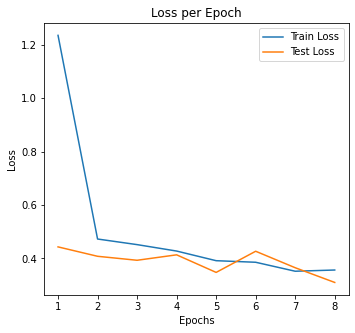

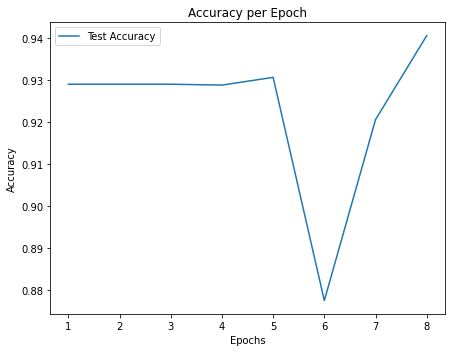

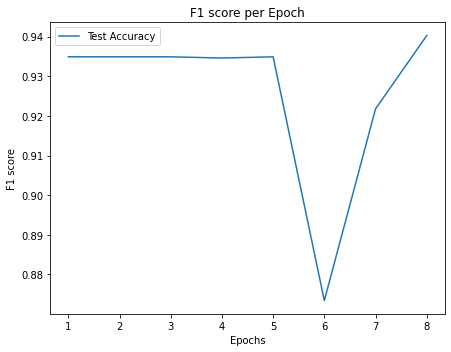

In [27]:
import matplotlib.pyplot as plt

epochs_ran = np.arange(1, 8 + 1)

    
# График потерь
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_ran, train_loss[:epochs], label='Train Loss')
plt.plot(epochs_ran, test_loss[:epochs], label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()

# График точности
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)
plt.plot(epochs_ran, test_acc[:epochs], label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()

plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)
plt.plot(epochs_ran, test_f1[:epochs], label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('F1 score')
plt.title('F1 score per Epoch')
plt.legend()

plt.tight_layout()
plt.show()

### I tried to set 5, 8, 10, 15 and 30 epochs in most of cases the overfitting starts after 7-8 epoch

In [28]:

# def test_model(text):
    
    
#     tokenized_text = tokenizer.encode_plus(
#             text,
#             add_special_tokens=True,  # Добавляет специальные токены [CLS], [SEP]
#             max_length=300, 
#             pad_to_max_length=True, # Ограничиваем максимальную длину
#             padding='max_length',     # Паддинг до MAX_LEN
#             truncation=True,          # Усечение длины
#             return_attention_mask=True,  # Возвращает маску внимания
#             return_tensors='pt'      # Возвращает тензоры PyTorch
#         )
    
# #     model = model.to(device)
    
#     model.eval()
#     with torch.no_grad():
#         outputs = model(input_ids=tokenized_text['input_ids'].to(device), attention_mask=tokenized_text['attention_mask'].to(device))

#     predictions = torch.argmax(outputs[0], dim=2)
#     predicted_labels = predictions[0].cpu().numpy()  
    
#     tokens = text.split()

#     labels = {k: v for v, k in tag2idx.items()}

#     res = {ent: [] for ent, _ in tag2idx.items()}    

#     for token, label_id in zip(tokens, predicted_labels):
#         label = model.config.id2label[label_id]  # Получаем лейбл по индексу
#         if 'Empty' not in {labels[label_id]}:
#             res[labels[label_id]].append(token)

#     return res

                